In [1]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "dataset/"
CLASS_NAMES = sorted([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [21]:
image_paths = []
labels = []

for i, folder in enumerate(CLASS_NAMES):
    folder_path = os.path.join(DATA_PATH, folder)
    for file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, file))
        labels.append(i)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total images:", len(image_paths))

Total images: 6436


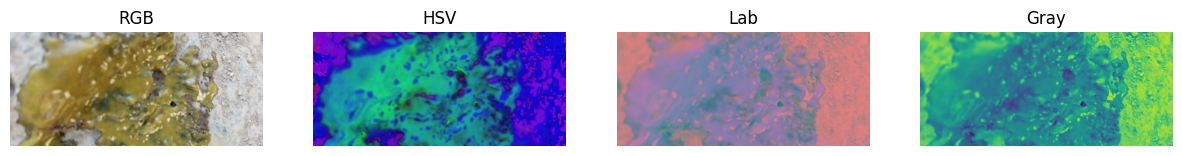

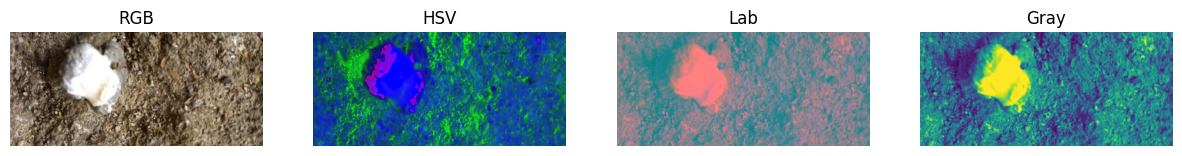

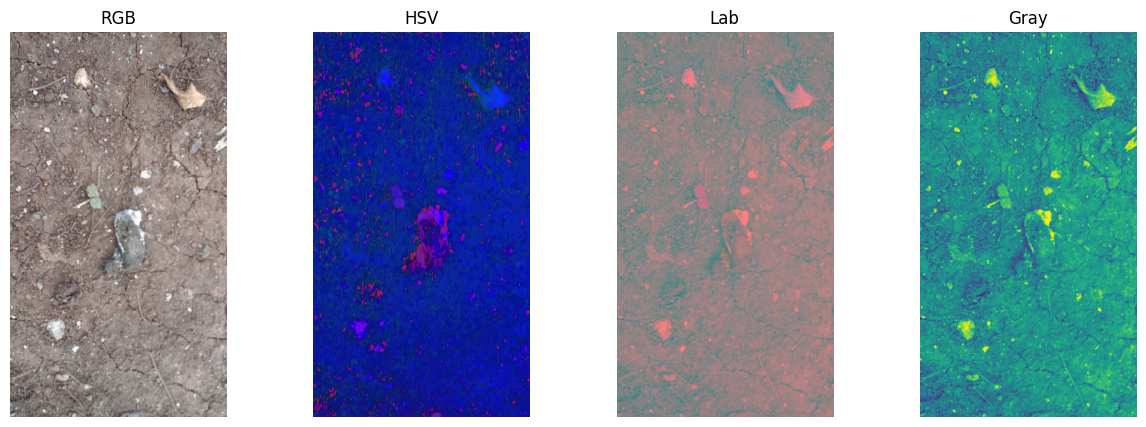

In [22]:
# Comparison between RGB, HSV, LAB
classes = ["cocci", "salmo", "healthy"]
for disease_class in classes:
    img_bgr = cv2.imread(DATA_PATH + f"{disease_class}/{disease_class}.0.jpg")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(img_rgb)
    axes[0].set_title('RGB')
    axes[0].axis('off')

    axes[1].imshow(img_hsv) 
    axes[1].set_title('HSV')
    axes[1].axis('off')

    axes[2].imshow(img_lab) 
    axes[2].set_title('Lab')
    axes[2].axis('off')

    axes[3].imshow(img_gray) 
    axes[3].set_title('Gray')
    axes[3].axis('off')

    plt.show()

In [23]:
X_train_path, X_temp_path, y_train, y_temp = train_test_split(
    image_paths,
    labels,
    test_size=0.30,
    random_state=42,
    stratify=labels
)

X_val_path, X_test_path, y_val, y_test = train_test_split(
    X_temp_path,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

### Feature Extraction

In [24]:
# Color Histogram Feature Extraction 
def color_histogram(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist_hue = cv2.calcHist([image], [0], None, [180], [0,180])
    hist_saturation = cv2.calcHist([image], [1], None, [256], [0,256])
    hist_value = cv2.calcHist([image], [2], None, [256], [0,256])

    cv2.normalize(hist_hue, hist_hue, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(hist_saturation, hist_saturation, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(hist_value, hist_value, 0, 255, cv2.NORM_MINMAX)

    color_feature_vector = np.concatenate((hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten())).astype(np.float32)
    return color_feature_vector

# Color Co-occurrence Matrix (CCM) Feature Extraction
def ccm_feature(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=16):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H_channel, S_channel, V_channel = cv2.split(image)

    channels = {'H': H_channel, 'S': S_channel, 'V': V_channel}
    all_features = []

    for name, img_channel in channels.items():
        # Quantize the channel to the specified number of levels
        max_val = np.max(img_channel)
        if max_val > 0:
            quantized_img = (img_channel * (levels - 1) / max_val).astype(np.uint8)
        else:
            quantized_img = np.zeros_like(img_channel, dtype=np.uint8)

        glcm = graycomatrix(
            quantized_img, 
            distances=distances, 
            angles=angles, 
            levels=levels, 
            symmetric=True, 
            normed=True
        )

        # Extract texture features (Contrast, Homogeneity, Energy, Correlation) for all angles/distances
        features_list = [
            graycoprops(glcm, prop).ravel() 
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        ]
        
        channel_features = np.concatenate(features_list)
        all_features.append(channel_features)
    
    final_feature_vector = np.concatenate(all_features)
    
    return final_feature_vector

# Sobel Feature Extraction (Shape)
def sobel_feature(image, n_bins_mag=16, n_bins_ang=16):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Gradient magnitude and orientation
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    orientation = np.arctan2(sobely, sobelx)

    # Flatten
    mag_flat = magnitude.ravel()
    ori_flat = orientation.ravel()

    # Avoid NaNs if image is constant
    if mag_flat.max() > 0:
        mag_flat = mag_flat / mag_flat.max()

    # Histogram of gradient magnitude (0–1)
    hist_mag, _ = np.histogram(
        mag_flat,
        bins=n_bins_mag,
        range=(0.0, 1.0),
        density=True
    )

    # Histogram of gradient orientation (-pi to pi)
    hist_ori, _ = np.histogram(
        ori_flat,
        bins=n_bins_ang,
        range=(-np.pi, np.pi),
        density=True
    )

    sobel_feat = np.concatenate([hist_mag, hist_ori]).astype(np.float32)
    return sobel_feat


In [25]:
def extract_features(image_array):
    features = []
    for img in image_array:
        ch = color_histogram(img) 
        # lbp = lbp_histogram(img)
        ccm = ccm_feature(img)  
        sobel = sobel_feature(img)
        feat = np.concatenate([ch, ccm, sobel])
        features.append(feat)

    return np.array(features, dtype=np.float32)

In [28]:
def detect_feces_bbox(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1. Blur → kurangi detail tanah
    blur = cv2.GaussianBlur(gray, (7, 7), 0)

    # 2. Adaptive Threshold     
    th = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        31, 5
    )

    # 3. Bersihkan noise kecil
    kernel = np.ones((5,5), np.uint8)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=2)

    # 4. Ambil contour
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None

    candidates = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        area = w * h

        # Minimum area yang masuk akal
        if area < 200:
            continue

        # Ratio w/h
        ratio = w / h
        if ratio < 0.2 or ratio > 5:
            continue

        # Local texture variance
        patch = gray[y:y+h, x:x+w]
        if patch.size == 0:
            continue

        variance = np.var(patch)
        if variance < 20:  # terlalu halus = air/kotoran lain
            continue

        candidates.append((c, area))

    if len(candidates) == 0:
        return None

    # ambil blob paling besar
    cnt = max(candidates, key=lambda x: x[1])[0]
    x, y, w, h = cv2.boundingRect(cnt)

    return x, y, w, h

In [29]:
def prepare_training_data(image_paths, labels):
    features = []
    new_labels = []

    for path, label in zip(image_paths, labels):
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

        bbox = detect_feces_bbox(img)
        if bbox is None:
            continue

        x, y, w, h = bbox
        roi = img[y:y+h, x:x+w]

        feat = extract_features([roi])[0]
        features.append(feat)
        new_labels.append(label)

    return np.array(features, dtype=np.float32), np.array(new_labels)

In [30]:
X_train_feat, y_train = prepare_training_data(X_train_path, y_train)
X_val_feat, y_val     = prepare_training_data(X_val_path, y_val)
X_test_feat, y_test   = prepare_training_data(X_test_path, y_test)

print("Train:", X_train_feat.shape)
print("Val  :", X_val_feat.shape)
print("Test :", X_test_feat.shape)

Train: (4488, 784)
Val  : (958, 784)
Test : (961, 784)


In [ ]:
def check_data(X, y, name):
    if len(X) == 0:
        raise ValueError(f"{name} set kosong setelah ROI detection")
    print(f"{name} samples:", len(X))

check_data(X_train_feat, y_train, "Train")
check_data(X_val_feat, y_val, "Validation")
check_data(X_test_feat, y_test, "Test")

### Rescale and PCA

In [31]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_val_scaled   = scaler.transform(X_val_feat)
X_test_scaled  = scaler.transform(X_test_feat)

pca = PCA(n_components=0.96, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)


print("Original dim:", X_train_scaled.shape[1])
print("Reduced dim:", X_train_pca.shape[1])

Original dim: 784
Reduced dim: 255


### Model Fitting & Tuning

#### SVC

In [32]:
svc = SVC(kernel='rbf', random_state=42, probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1.0]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', 
    n_jobs=1, 
    verbose=2
)

grid_search.fit(X_train_pca, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=  30.5s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=  27.4s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=  29.6s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=  30.9s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=  31.8s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=  19.3s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 14.6min


[CV] ................................ C=10, gamma=0.001, total=   8.6s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................................ C=10, gamma=0.001, total=   8.7s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................................ C=10, gamma=0.001, total=   9.1s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................................ C=10, gamma=0.001, total=   8.6s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................................ C=10, gamma=0.001, total=   8.6s
[CV] C=10, gamma=0.01 ................................................
[CV] ................................. C=10, gamma=0.01, total=   7.7s
[CV] C=10, gamma=0.01 ................................................
[CV] ................................. C=10, gamma=0.01, total=   7.4s
[CV] C=10, gamma=0.01 ................................................
[CV] .

In [33]:
# SVC
best_svm = grid_search.best_estimator_

best_svm.fit(X_train_pca, y_train)

# Validation performance
y_val_pred = best_svm.predict(X_val_pca)
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation classification report:\n", classification_report(y_val, y_val_pred))

# Test performance:
y_test_pred = best_svm.predict(X_test_pca)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Test classification report:\n", classification_report(y_test, y_test_pred))

print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))

Validation accuracy: 0.8956158663883089
Validation classification report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       315
           1       0.89      0.92      0.90       302
           2       0.88      0.84      0.86       341

    accuracy                           0.90       958
   macro avg       0.90      0.90      0.90       958
weighted avg       0.90      0.90      0.90       958

Test accuracy: 0.9021852237252862
Test classification report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       316
           1       0.90      0.91      0.91       303
           2       0.89      0.85      0.87       342

    accuracy                           0.90       961
   macro avg       0.90      0.90      0.90       961
weighted avg       0.90      0.90      0.90       961

Confusion matrix (test):
 [[299   4  13]
 [  2 277  24]
 [ 23  28 291]]


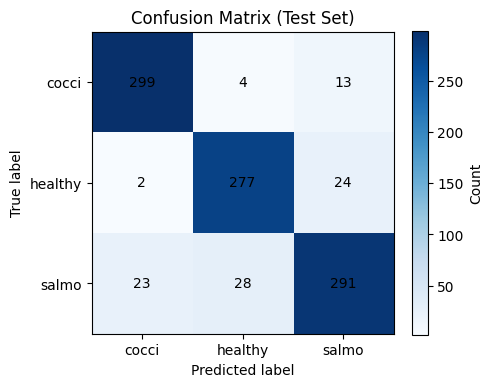

In [34]:
cm = confusion_matrix(y_test, y_test_pred)
classes = CLASS_NAMES

plt.figure(figsize=(5, 4))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')

plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i,
            str(cm[i, j]),
            ha="center", va="center"
        )

cbar = plt.colorbar(im)
cbar.set_label('Count')

plt.tight_layout()
plt.show()

In [35]:
def predict_with_detection(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

    # Detect feces bbox
    bbox = detect_feces_bbox(img_resized)
    if bbox is None:
        print("Tidak ada objek terdeteksi")
        return None, None, img_resized, None

    x, y, w, h = bbox

    # Crop ROI
    crop = img_resized[y:y+h, x:x+w]

    # Feature extraction
    feat = extract_features([crop])
    feat_scaled = scaler.transform(feat)
    feat_pca = pca.transform(feat_scaled)

    # Predict with SVM
    pred_idx = best_svm.predict(feat_pca)[0]
    pred_class = CLASS_NAMES[pred_idx]

    # Draw bounding box
    boxed = img_resized.copy()
    cv2.rectangle(boxed, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(
        boxed, pred_class,
        (x, y-10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.7,
        (0,255,0), 2
    )

    return pred_idx, pred_class, boxed, bbox

Predicted label index: 2
Predicted class name: salmo


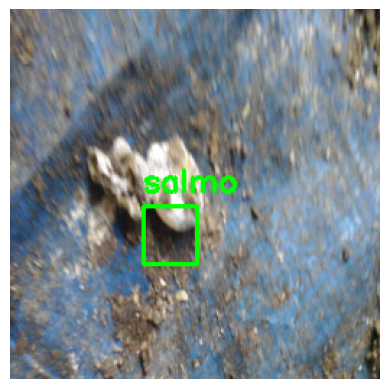

In [36]:
img_path = "./dataset/salmo/salmo.3.jpg"

pred_idx, pred_class, boxed_img, bbox = predict_with_detection(img_path)

print("Predicted label index:", pred_idx)
print("Predicted class name:", pred_class)

plt.imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [37]:
import pickle

model_bundle = {
    "scaler": scaler,
    "pca": pca,
    "model": best_svm,
    "class_names": CLASS_NAMES
}

with open("svm_final.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

print("Model + scaler + PCA saved!")


Model + scaler + PCA saved!
